<a href="https://colab.research.google.com/github/MinsooKwak/image_caption/blob/main/image_caption_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<strong>
        <center><h4 style = "margin-right:60px"><font size = 6> Image Caption with Attention</font></h4></center>
    </strong>

In [ ]:
#Import all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import collections
from collections import Counter
import string
import time

# for deep learning
import tensorflow as tf
import keras

# 이미지 처리 및 자연어 처리
from tensorflow.keras.utils import load_img
from PIL import Image
from IPython import display
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
# progress bar
from tqdm import tqdm

# import models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

# for modeling
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input

# 파일 경로명을 통해 파일 리스트를 뽑기 위한 라이브러리
import glob
import os

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [ ]:
#root_directory = '/content/drive/MyDrive/ImageCaption/Data/flickr8k' # colab
#root _directory = '/kaggle/input'

# directory에서 파일명 불러오기
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/kaggle/input/flickr8k/Images/2100735137_05c6079537.jpg
/kaggle/input/f

 <h2> Data Understanding and Visualization
</h2><ul>
  <li><p>Import the dataset and read image and captions into two seperate variables</p>
        </li>
  <li><p>Visualise both the images & text present in the dataset</p></li>
  <li>Visualise the top 30 occuring words in the captions
</li>
    li>Visualise the top 30 occuring words in the captions
</li>
<li>Create a list which contains all the captions & path</li>
</ul>





In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#images = '/content/drive/MyDrive/images' # colab
images='/kaggle/input/flickr8k/Images' # kaggle note

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


/tmp/ipykernel_20/4049178909.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax.imshow(imageio.imread(image), cmap=None)


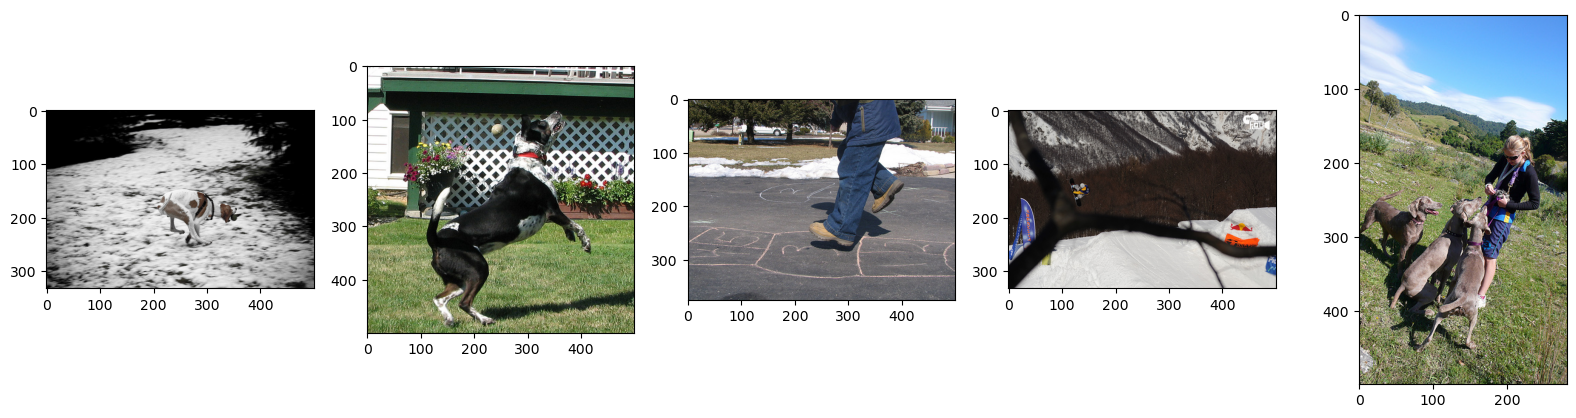

In [ ]:
# image 불러오는 library (cv2가 속도가 더 빠름)
import imageio

Display_Images = all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)

for ax, image in zip(axes, Display_Images):
  ax.imshow(imageio.imread(image), cmap=None)

In [ ]:
#text_file = '/content/captions.txt' # colab
text_file = '/kaggle/input/flickr8k/captions.txt'   # kaggle notebook

df = pd.read_csv(text_file)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
df2 = pd.DataFrame(df.image.value_counts())
df2 = df2.reset_index()
df2

,index,image
0,1000268201_693b08cb0e.jpg,5
1,3388094307_5a83be64a5.jpg,5
2,3393394134_0caac47e1c.jpg,5
3,3393343330_b13df4d8ec.jpg,5
4,3393152604_27bd1037f2.jpg,5
...,...,...
8086,2699733386_c346c87ea6.jpg,5
8087,2699426519_228719b1db.jpg,5
8088,2699342860_5288e203ea.jpg,5
8089,2699125097_c6801d80ed.jpg,5


In [ ]:
df2.image.value_counts()

5    8091
Name: image, dtype: int64

In [ ]:
#img_path = '/content/drive/MyDrive/images/' # colab
img_path = '/kaggle/input/flickr8k/Images/' # kaggle notebook

df['path'] = img_path + df['image']
df.shape
df.head()

,image,caption,path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/kaggle/input/flickr8k/Images/1000268201_693b0...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/kaggle/input/flickr8k/Images/1000268201_693b0...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/kaggle/input/flickr8k/Images/1000268201_693b0...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,/kaggle/input/flickr8k/Images/1000268201_693b0...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,/kaggle/input/flickr8k/Images/1000268201_693b0...


In [ ]:
'''
all_img_id = []
all_img_vector = []
annotations = []

with open('/kaggle/input/flickr8k/captions.txt' , 'r') as fo:
  next(fo)
  for line in fo :
    split_arr = line.split(',')
    all_img_id.append(split_arr[0])
    annotations.append(split_arr[1].rstrip('\n.')) #removing out the \n.
    all_img_vector.append(img_path+split_arr[0])

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])
df
'''

"\nall_img_id = [] \nall_img_vector = [] \nannotations = [] \n\nwith open('/kaggle/input/flickr8k/captions.txt' , 'r') as fo:\n  next(fo) \n  for line in fo :\n    split_arr = line.split(',')\n    all_img_id.append(split_arr[0])\n    annotations.append(split_arr[1].rstrip('\n.')) #removing out the \n.\n    all_img_vector.append(img_path+split_arr[0])\n\ndf = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])   \ndf\n"

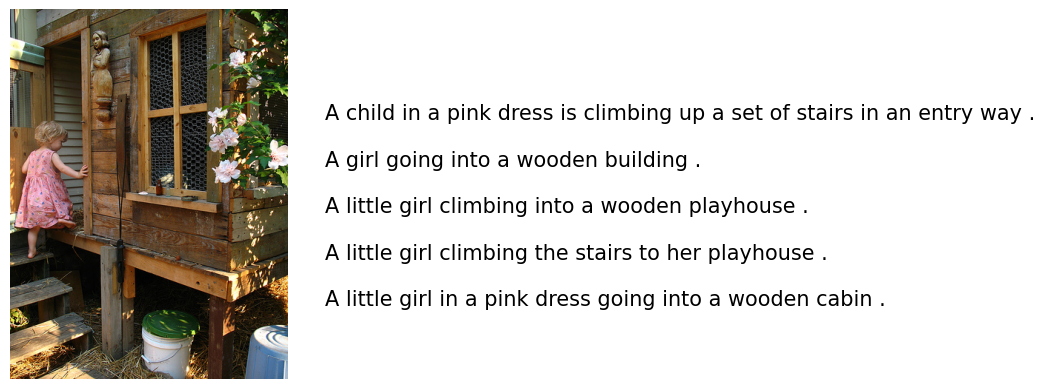

In [ ]:
def caption_with_img(image_id, frame):
  capt = ('\n'*2).join(frame[frame['image'] == image_id].caption.to_list())
  fig, ax = plt.subplots()
  ax.set_axis_off()
  idx = df.image.to_list().index(image_id)
  im = Image.open(df.path.iloc[idx])
  width, height = im.size[0], im.size[-1]
  ax.imshow(im)
  ax.text(width+50,height-100, capt, fontsize=15, color='black')

caption_with_img(df.image.iloc[3],df)


 <h2> Preprocessing




In [ ]:
def word_prep(str):
  str = str.replace('coca','')
  str = str.replace('cola','coca-cola')
  str = str.replace('hapily','happily')
  str = str.replace('playy','play')
  str = str.replace('fronmt','front')
  str = str.replace('litle','little')
  str = str.replace('offf','off')
  str = str.replace('giong','going')
  str = str.replace('rakes','lakes')
  str = str.replace('sidwalk','sidewalk')
  str = str.replace('mommy','mom')
  str = str.replace('woamn','woman')
  str = str.replace('feamle','female')
  str = str.replace('matchin','matching')
  str = str.replace('jello','hello')
  str = str.replace('silohuetted','silhouetted')
  str = str.replace('redhead','red head')
  str = str.replace('ypoung','young')
  str = str.replace('unner','under')
  return str

In [ ]:
df['caption'] = df['caption'].apply(word_prep)
df.head()

,image,caption,path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/kaggle/input/flickr8k/Images/1000268201_693b0...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/kaggle/input/flickr8k/Images/1000268201_693b0...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/kaggle/input/flickr8k/Images/1000268201_693b0...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,/kaggle/input/flickr8k/Images/1000268201_693b0...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,/kaggle/input/flickr8k/Images/1000268201_693b0...


In [ ]:
# #Create a list that contains path to the images
# all_img_path = [i for path_list in df['path'] for i in path_list]
# # print(len(all_img_path))
# print(all_img_path[:50])

 <h2> Tokenizing</h2>
 <ul>
  <li><p>특정한 구두점 문자를 대체하고 나머지 공백 문자를 기반으로 분할을 진행하는 keras tokenizer의 특성을 고려해 keras를 통한 토큰화 진행하기로 결정.<p>


In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def token_word(string):
  '''
  token화 후 토큰들을 list로 return하는 함수 정의
  '''
  str_list = text_to_word_sequence(string)
  return str_list

In [ ]:
df['token_list'] = df.caption.apply(token_word)
df['len'] = df.token_list.apply(lambda x : len(x))

In [ ]:
df.head()

,image,caption,path,token_list,len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, child, in, a, pink, dress, is, climbing, u...",17
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, girl, going, into, a, wooden, building]",7
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, little, girl, climbing, into, a, wooden, p...",8
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, little, girl, climbing, the, stairs, to, h...",9
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, little, girl, in, a, pink, dress, going, i...",12


In [ ]:
df.describe()

,len
count,40455.000000
mean,10.818564
std,3.770195
min,1.000000
25%,8.000000
50%,10.000000
75%,13.000000
max,37.000000


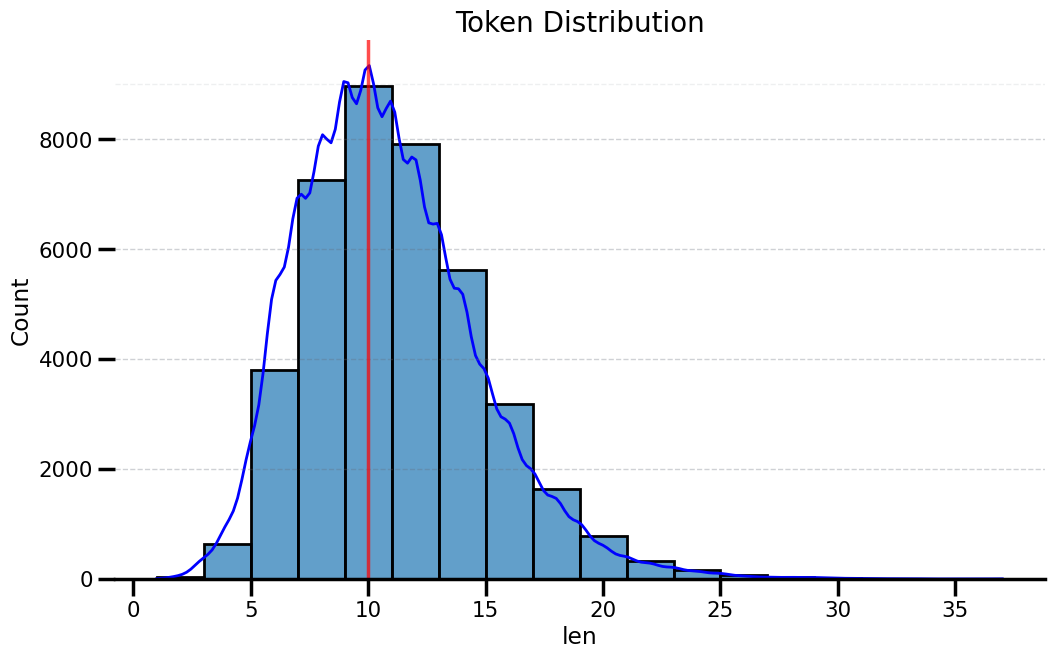

In [ ]:
sns.set_context("poster", font_scale = 0.7, rc={"grid.linewidth": 5})

fig1, axes = plt.subplots(1,1, figsize=(12,7))
fig1.gca().spines['right'].set_visible(False)   # 오른쪽 테두리 제거
fig1.gca().spines['top'].set_visible(False)     # 위 테두리 제거
fig1.gca().spines['left'].set_visible(False)    # 왼쪽 테두리 제거

ax1 = sns.histplot(df, x='len', binwidth=2, alpha=0.7, kde=True,
                   line_kws={'lw':2}
                   ## 'color':'b' 적용이 안되서 대안으로 아래 방식 활용
                   )
ax1.lines[0].set_color('b')

# 값의 폭을 10단위로 확인해봄 # bins=n 통해 bin 개수 조절 가능
ax1.set_title('Token Distribution', fontsize=20)

# y축 설정
plt.axhline(y=2000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=4000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=6000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=8000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=9000, color='#626774', linestyle='--', linewidth=1, alpha=0.1)

# # x 축 설정
# plt.axvline(x=0, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
# plt.axvline(x=25, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
# plt.axvline(x=50, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
# plt.axvline(x=75, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
# plt.axvline(x=90, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
# plt.axvline(x=105, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
# plt.axvline(x=120, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
# plt.axvline(x=135, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
# plt.axvline(x=150, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
# plt.axvline(x=165, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
# plt.axvline(x=180, color='#626774', linestyle='--', linewidth=1, alpha=0.1)

# 중위수 표시
plt.axvline(x=df['len'].median(), color='r', linestyle='-', linewidth=2.5, alpha=0.7)

### Dictionary 생성 및 불용어 제외

In [ ]:
# tokenizer + embedding 가능 정의
word_dict_limit = 5000  # dict 크기 제한시 사용 # None 가능
tokenizer = Tokenizer(num_words = word_dict_limit+1,
                      filters = '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, # 소문자 반환
                      char_level = False, # True일 경우 모든 문자 토큰으로 처리
                      oov_token = 'UNK')  # 지정시 text_to_sequence 호출 과정에 word_index에 추가되어 oov words 대체

In [ ]:
df.head()

,image,caption,path,token_list,len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, child, in, a, pink, dress, is, climbing, u...",17
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, girl, going, into, a, wooden, building]",7
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, little, girl, climbing, into, a, wooden, p...",8
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, little, girl, climbing, the, stairs, to, h...",9
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, little, girl, in, a, pink, dress, going, i...",12


In [ ]:
import nltk
from nltk.corpus import stopwords

# 불용어 다운
nltk.download('stopwords')

# 불용어 집합에 담음
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Counter를 통해 중복된 데이터가 저장된 배열에서 각 원소가 몇 번씩 저장되었는지 확인
from collections import Counter

combined_token_list = [i for tok_list in df['token_list'] for i in tok_list] # 하나의 리스트에 담음
print(len(combined_token_list))

437665


In [ ]:
frequent = Counter(combined_token_list).most_common()
#print(f'unique한 token의 개수 : {len(words)}')
print(len(frequent))

8478


In [ ]:
frequent_df = pd.DataFrame(frequent)
frequent_df.T

,0,1,2,3,4,5,6,7,8,9,...,8468,8469,8470,8471,8472,8473,8474,8475,8476,8477
0,a,in,the,on,is,and,dog,with,man,of,...,swatting,containig,rainstorm,breezeway,cocker,spaniels,weight,majestically,scrolled,patterns
1,62992,18986,18419,10745,9345,8862,8138,7765,7274,6723,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
remove_stopwords = [x for x in combined_token_list if x not in stop_words]
frequent2 = Counter(remove_stopwords).most_common()
print(len(frequent2))

8360


In [ ]:
frequent_df2 = pd.DataFrame(frequent2)
# 불용어 파악 위해 리스트 csv 저장
frequent_df2.to_csv('stopword_prepare.csv')

In [ ]:
####### 보고 불용어 파악
## 숫자는 주요 정보일 수 있으므로 제거하지 않겠음
stopword2 = ['s',"'",'st','c','u','p','v','n','ac','ou',"n'",'gin','od','lav','kelp','nd','gren',
             'tbe','gith','dhe','h','la','osme','ot','djs','hte','fronr','ox','shire','hdr','rung',
             'boe','twp','vfw','ti','chi','tho','ont','mma','iove','ump','outise','lei','pf','ee',
             'thong','tge','ilks','r','floatlys','stucco','arc','brwon'] # 'start','end'

In [ ]:
def filter_tokens(string):
  string = [s for s in string if s not in stop_words]
  string = [s for s in string if s not in stopword2]
  return string

In [ ]:
df['filtered_token']=df['token_list'].apply(filter_tokens)
df['filtered_len']=df['filtered_token'].apply(len)
df.head()

,image,caption,path,token_list,len,filtered_token,filtered_len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, child, in, a, pink, dress, is, climbing, u...",17,"[child, pink, dress, climbing, set, stairs, en...",8
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, girl, going, into, a, wooden, building]",7,"[girl, going, wooden, building]",4
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, little, girl, climbing, into, a, wooden, p...",8,"[little, girl, climbing, wooden, playhouse]",5
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, little, girl, climbing, the, stairs, to, h...",9,"[little, girl, climbing, stairs, playhouse]",5
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, little, girl, in, a, pink, dress, going, i...",12,"[little, girl, pink, dress, going, wooden, cabin]",7


In [ ]:
def add_pad(tokens):
  padded_tokens = ['<start>'] + tokens + ['<end>']
  return padded_tokens

df['filtered_token'] = df['filtered_token'].apply(add_pad)
df.head()

,image,caption,path,token_list,len,filtered_token,filtered_len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, child, in, a, pink, dress, is, climbing, u...",17,"[<start>, child, pink, dress, climbing, set, s...",8
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, girl, going, into, a, wooden, building]",7,"[<start>, girl, going, wooden, building, <end>]",4
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, little, girl, climbing, into, a, wooden, p...",8,"[<start>, little, girl, climbing, wooden, play...",5
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, little, girl, climbing, the, stairs, to, h...",9,"[<start>, little, girl, climbing, stairs, play...",5
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[a, little, girl, in, a, pink, dress, going, i...",12,"[<start>, little, girl, pink, dress, going, wo...",7


In [ ]:
# word-to-index mapping
tokenizer.fit_on_texts(df['filtered_token'])

# embedding (integer)
train_seqs = tokenizer.texts_to_sequences(df['filtered_token'])

In [ ]:
# PAD에 zero 더함
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [ ]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [ ]:
print(tokenizer.num_words)
tokenizer.index_word

5001


{1: 'UNK',
 2: '<start>',
 3: '<end>',
 4: 'dog',
 5: 'man',
 6: 'two',
 7: 'white',
 8: 'black',
 9: 'boy',
 10: 'woman',
 11: 'girl',
 12: 'wearing',
 13: 'people',
 14: 'water',
 15: 'red',
 16: 'young',
 17: 'brown',
 18: 'blue',
 19: 'dogs',
 20: 'running',
 21: 'playing',
 22: 'shirt',
 23: 'standing',
 24: 'ball',
 25: 'little',
 26: 'grass',
 27: 'snow',
 28: 'child',
 29: 'person',
 30: 'jumping',
 31: 'front',
 32: 'three',
 33: 'sitting',
 34: 'holding',
 35: 'field',
 36: 'small',
 37: 'large',
 38: 'green',
 39: 'one',
 40: 'group',
 41: 'yellow',
 42: 'walking',
 43: 'children',
 44: 'men',
 45: 'air',
 46: 'beach',
 47: 'near',
 48: 'mouth',
 49: 'jumps',
 50: 'another',
 51: 'street',
 52: 'runs',
 53: 'riding',
 54: 'stands',
 55: 'bike',
 56: 'girls',
 57: 'outside',
 58: 'rock',
 59: 'next',
 60: 'play',
 61: 'orange',
 62: 'looking',
 63: 'pink',
 64: 'player',
 65: 'camera',
 66: 'pool',
 67: 'hat',
 68: 'jacket',
 69: 'boys',
 70: 'women',
 71: 'around',
 72: 'beh

### Remove stopwords

(0.0, 9500.0)

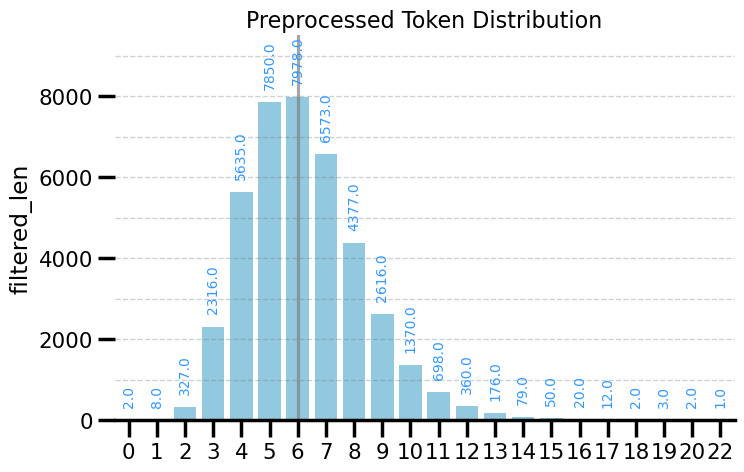

In [ ]:
sns.set_context("poster", font_scale = 0.7, rc={"grid.linewidth": 5})

fig2, axes2 = plt.subplots(1,1, figsize=(8,5))
fig2.gca().spines['right'].set_visible(False)   # 오른쪽 테두리 제거
fig2.gca().spines['top'].set_visible(False)     # 위 테두리 제거
fig2.gca().spines['left'].set_visible(False)    # 왼쪽 테두리 제거

ax2 = sns.barplot(x=df['filtered_len'].value_counts().index, y=df['filtered_len'].value_counts(), color='skyblue')

# 값의 폭을 10단위로 확인해봄 # bins=n 통해 bin 개수 조절 가능
ax2.set_title('Preprocessed Token Distribution', fontsize=16)

# y축 설정
plt.axhline(y=1000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=2000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=3000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=4000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=5000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=6000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=7000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=8000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=9000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)

# 중위수 표시
plt.axvline(x=df['filtered_len'].median(), color='gray', linestyle='-', linewidth=2.3, alpha=0.7)

for p in ax2.patches:
  height = p.get_height()
  ax2.text(p.get_x() + p.get_width()/2., height+400, height, ha='center', color='#3399FF', fontsize=10, rotation=90)
ax2.set_ylim(0,9500)

### 빈도어

In [ ]:
# 하나의 리스트에 담음
filtered_token_list = [i for tok_list in df['filtered_token'] for i in tok_list]

# Top15 단어
freq = Counter(filtered_token_list).most_common()
filtered_freq_df = pd.DataFrame(freq)
filtered_freq_df.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,<start>,<end>,dog,man,two,white,black,boy,woman,girl,wearing,people,water,red,young
1,40455,40455,8138,7274,5642,3959,3848,3581,3403,3328,3062,2883,2790,2714,2630


### Pad vector to max_length caption

In [ ]:
train_seqs_len = [len(seq) for seq in train_seqs]

max_word_length = max(train_seqs_len)

caption_vec = tf.keras.preprocessing.sequence.pad_sequences(train_seqs,
                                                            padding='post',
                                                            maxlen=max_word_length,
                                                            dtype='int32',
                                                            value=0)

print(f'Caption vector shape : {caption_vec.shape}')

Caption vector shape : (40455, 24)


## Image Preprocessing

In [ ]:
# check image format (이미지 데이터 형식 규칙의 값을 설정)
tf.keras.backend.image_data_format()

'channels_last'

- 2차원 데이터
    - "channels_last" : (rows, cols, channels)를 상정
    - "channels_first" : (channels, rows, cols)를 상정


- 3차원 데이터
    - "channels_last" : (conv_dim1, conv_dim2, conv_dim3, channels)를 상정
    - "channels_first" : (channels, conv_dim1, conv_dim2, conv_dim3)을 상정

In [ ]:
prep_img = []
IMAGE_SHAPE = (299, 299)

for img in all_imgs[0:5] :
    img = tf.io.read_file(img, name=None)
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    prep_img.append(img)

resized shape : (299, 299, 3)
resized shape : (299, 299, 3)
resized shape : (299, 299, 3)
resized shape : (299, 299, 3)
resized shape : (299, 299, 3)


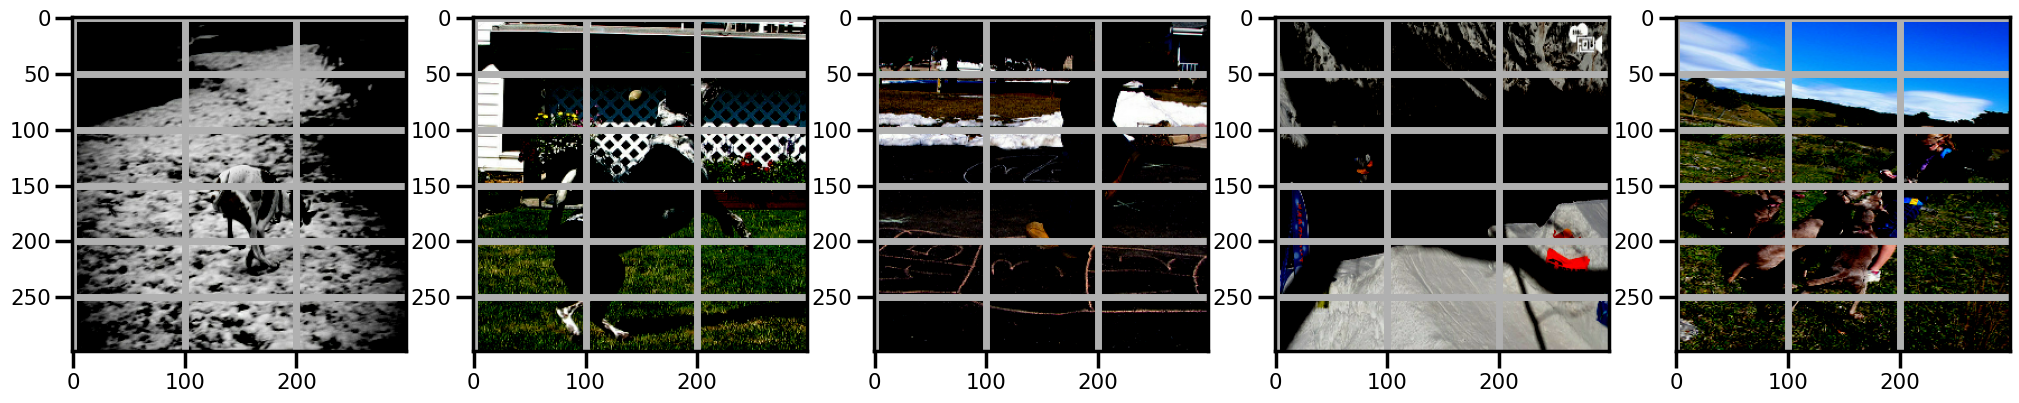

In [ ]:
# check images post preprocessed
Display_Images = prep_img[0:5]
fig, axes = plt.subplots(1,5)
fig.set_figwidth(25)

for ax, image in zip(axes, Display_Images):
  print(f'resized shape : {image.shape}')
  ax.imshow(image)
  ax.grid('off')

### Processing Image

In [ ]:
def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [ ]:
training_list = sorted(set(df['path']))
New_Img = tf.data.Dataset.from_tensor_slices(training_list)
New_Img = New_Img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)
New_Img = New_Img.batch(64, drop_remainder=False)

In [ ]:
path_train, path_test, caption_train, caption_test = train_test_split(df['path'], caption_vec, test_size=0.2, random_state = 24)

print(f'Train data (images)  : {str(len(path_train))}')
print(f'Test  data (images)  : {str(len(path_test))}')
print(f'Train data (caption) : {str(len(caption_train))}')
print(f'Test  data (caption) : {str(len(caption_test))}')

Train data (images)  : 32364
Test  data (images)  : 8091
Train data (caption) : 32364
Test  data (caption) : 8091


# Modeling

## Load pretrained InceptionNetV3

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top = False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
inceptionv3_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
inceptionv3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

### Feature Extracting

In [ ]:
img_features = {}
for img, image_path in tqdm(New_Img):
  batch_features = inceptionv3_model(img)
  # squeeze features in batch
  flattened_feature = tf.reshape(batch_features, (batch_features.shape[0],-1, batch_features.shape[3]))

  for batch_feat, path in zip(flattened_feature, image_path):
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

100%|██████████| 127/127 [17:10<00:00,  8.11s/it]


In [ ]:
batch_features

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.0000000e+00, 7.7467650e-02, 0.0000000e+00, ...,
          2.3183759e-01, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          1.0778813e-01, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 1.9403169e-01, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.8575513e-01],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          9.4265595e-02, 0.0000000e+00, 5.0578970e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 4.2300537e-01, 1.3446197e-02, ...,
          2.3367137e-01, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          4.9979120e-02, 0.0000000e+00, 0.0000000e+00]

In [ ]:
flattened_feature

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.0000000e+00, 7.7467650e-02, 0.0000000e+00, ...,
         2.3183759e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.0778813e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.9403169e-01, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 1.8575513e-01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 1.6569363e+00, 0.0000000e+00],
        [0.0000000e+00, 4.0261021e-01, 0.0000000e+00, ...,
         0.0000000e+00, 3.1791839e-01, 0.0000000e+00],
        [0.0000000e+00, 2.5347540e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.2506025e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 7.8497171e-02, ...,
         1.2064208e+00, 0.0000000e+00, 0.0000000e+00],
        [0.000000

In [ ]:
batch_feat.shape

TensorShape([64, 2048])

In [ ]:
import more_itertools

# 상위 5개 feature dict 확인하기
top_5 = more_itertools.take(5, img_features.items())
top_5

[('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.1698712 ],
         [0.        , 0.        , 1.0105925 , ..., 0.        , 0.        ,
          0.06111747],
         ...,
         [0.        , 0.        , 2.038041  , ..., 1.2029699 , 0.        ,
          1.992411  ],
         [0.        , 0.        , 0.9046886 , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 1.2527242 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.66367984, 0.46286014, ..., 0.        , 0.        ,
          3.3322585 ],
         [0.        , 1.2268146 , 0.        , ..., 0.        , 0.25390285,
          3.3295312 ],
         [1.2881926 , 1.5195405 , 0.        , ..., 0.46777815,

In [ ]:
def map(image_name, caption):
    '''
    # image, caption을 동시에 시각화하기 위한 함수 정의
    1. feature extracting 단계에서 flattened한 feature에서 설정한
        img_features[feature_path] utf-8로 decoding
    '''
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [ ]:
'''
# 병렬 매핑
benchmark(
    ArtificialDataset()
    .map(
        mapped_function,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)
'''

'\n# 병렬 매핑\nbenchmark(\n    ArtificialDataset()\n    .map(\n        mapped_function,\n        num_parallel_calls=tf.data.experimental.AUTOTUNE\n    )\n)\n'

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64


def gen_dataset(img, capt):
    '''
    1. tf.data.Dataset.from_tensor_slices() : 메모리에 로드된 데이터를 이용하여 Dataset을 생성
    -- tensor로부터 slices를 생성
    -- 학습 데이터 shape이 (60000, 28, 28)라면 -> 60000 slices, slices는 (28, 28)의 이미지 크기를 갖게 됨

    2. Dataset().map(mapped_function, num_parallel_calls=tf.data.experimenetal,AUTOTUNE)
    -- 동일한 전처리 함수를 여러 샘플에 병렬적으로 적용
    -- 참고 : https://notebook.community/tensorflow/docs-l10n/site/ko/guide/data_performance

    3. Dataset.shuffle(buffer_size=3, seed=42, reshuffle_each_iteration=True).batch(7)
    -- reshuffle_each_iteration=False : 반복마다 동일한 순서를 사용할 수 있음
    -- buffer size : 해당 개수만큼 추출해 buffer에 채움
        -- 랜덤하게
        -- 모든 아이템이 사용될때까지
        -- 셔플링 효과를 올리기 위해 충분히 크게 해야 함
        -- 유의 : 메모리 크기 및 데이터의 크기를 넘지 않게
    -- 참고 : https://doubly8f.netlify.app/%EA%B0%9C%EB%B0%9C/2020/08/19/tf-loading-preprocessing-data/
    -- 참고 : https://ahnjg.tistory.com/32

    4. Dataset.batch(drop_remainder=True)
    -- drop_remainder : 마지막 남은 데이터를 drop 할 것인지 여부
    -- drop_remainder=True일 때 나머지를 버릴 수 있음

    5. tf.data.Dataset.prefetch
    -- prefetching : 전처리와 훈련 스텝의 모델 실행을 오버랩 (가져옴)
    -- 요청된 시간 전에 입력 데이터셋에서 데이터를 가져옴
    -- 가져올 데이터의 수 >= 하나의 훈련 스텝에서 소비한 배치의 수
    -- tf.data.experimental.AUTOTUNE : tf.data 런타임 실행시 동적으로 값
    '''
    # 데이터셋 생성
    data = tf.data.Dataset.from_tensor_slices((img, capt))

    # .map(mapped_function, num_parallel_calls=tf.data.experimenetal,AUTOTUNE) 통한 병렬 처리
    # tf.numpy_function() : 파이썬 함수를 매핑하여 tensorflow operation에 활용
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)

    # 데이터 셔플 및 가져오기
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(batch_size = BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    return data

In [ ]:
train_dataset = gen_dataset(path_train,caption_train)
test_dataset = gen_dataset(path_test,caption_test)

In [ ]:
# next(반복 가능한 객체, 기본값) 반복할 수 있을 때는 해당 값을 출력, 반복이 끝났을 때는 기본값을 출력
'''
1. 데이터의 구조를 파악할 수 있음
    - batch_size, feature map 크기, caption 길이
2. 디버깅, 테스트 가능
    - next(iter(train_dataset)) 통해 첫 번째 배치 가져올 수
    - 올바르게 로드되고 순환되는지 확인 가능
3. 반복 작업을 위한 효율성 : 다음 배치를 가져올 수 있음
'''
sample_img_batch, sample_cap_batch = next(iter(train_dataset))

print(f'현재 배치의 이미지 데이터 모양 : {sample_img_batch.shape}')
#(batch_size, 8*8, 2048) # 배치 크기에 따라 달라짐
# 각 이미지는 8*8 크기의 feature vector로 표현
# 각 feature vector는 2048 차원

print(f'현재 배치의 caption 데이터의 모양 : {sample_cap_batch.shape}')
#(batch_size,max_len) # 배치 크기에 따라 달라짐
# max_len : 각 캡션은 최대 길이로 표현됨
# -- 해당 정보를 통해 각 캡션의 최대 길이를 파악할 수 있음

현재 배치의 이미지 데이터 모양 : (64, 64, 2048)
현재 배치의 caption 데이터의 모양 : (64, 24)


<h2> Model Building</h2>

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
# Parameter 설정
embedding_dim = 256 # 결과 embedding 크기
units = 512

# vocab size 및 step 조정
vocab_size = 5001   # top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

max_length = 31
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

## Encoder

In [ ]:
# 그래프 초기화, 이전 정의된 텐서 및 연산 제거
# 이전에 구성된 모델과의 충돌을 방지하고 새로운 모델 구축 및 활용 가능
# tensorflow 1.x에서 활용 / 2.x 부터는 그래프 초기화 관련 문제는 사라짐
# 대신 tf.function 데코레이터를 활용해 그래프를 정적으로 컴파일 및 최적화할 수 있음

tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__() # 부모 클래스의 생성자를 불러와 상속받음
        self.dense = tf.keras.layers.Dense(embed_dim)

    def call(self, features):
        '''
        모델의 동작을 정의
        1) self.dense(features) : Feature extract (FC layer)
        -- 선형 변환 수행 : 입력 데이터 * 가중치 행렬 + bias
        -- 데이터 형상 변환, 데이터 포함된 주요 특성 추출에 도움

        2) relu 활성화함수 사용
        -- # ReLU(x)= max(0,x)
        -- alpha : 음수 부분의 기울기 (default=0)
            -- alpha=0.01 : Leaky ReLU (음수값이 모두 0이 되는 것 방지 위함)
        -- max_value : ReLU의 출력값 제한
            -- max_value =6 : 출력값이 6보다 큰 경우 6 출력
        -- threshold : 임계값 활성화를 위한 값
            -- 입력값이 0보다 작을 때 0 출력
            -- threshold 설정시 다른 값 출력되도록 조절
            -- ex) threshold=0.2 -> 0.2보다 작을 때 0 대신 음수 출력
        '''
        features =  self.dense(features) # image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [ ]:
encoder=Encoder(embedding_dim)

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        '''
        1. bahdanau attention은 Key, Value 동일
        -- query가 decoder cell의 t-1 시점의 은닉 상태
        2. hidden_with_time_axis
        -- score 계산을 위해 뒤에서 할 덧셈을 위해 차원을 변경해줌
        -- 3가지 방안
            1) expand_dims : 늘리고 싶은 axis 지정하면 해당 axis에 차원 추가됨
            -- -1 이면 가장 뒷부분 차원 추가
            2) tf.newaxis : 기존 배열을 적고 추가하고 싶은 위치에 적으면 간단히 size 변경 가능
            -- 차원이 정해져 있지 않음, 간단히 변경
            3)reshape() : 차원이 정해져 있음
        3. score 계산
        -- score(s_(t), h_{i}) = W_{a}^T * tanh(W_{b}*s_{t} + W_{c}*H_{i}})
        4. tf.reduce_sum() : # 텐서의 차원을 탐색해 개체의 총합을 계산
        -- tf.reduce_sum(x,0) : 열 단위로 sum
        -- tf.reduce_sum(x,1) : 행 단위로 sum
        -- tf.reduces_sum(x,1, keep_dims=True) : keep_dims= 원래 상태 유지
        '''
        # 1. score 계산 위한 차원 변경
        hidden_with_time_axis = hidden[:, tf.newaxis]

        # 2. score 계산
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # 3. attention weight 구함
        # attention distribution의 각 값인 attention_weight를 구함
        # -- softmax()를 활용해 attention distribution을 구함
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1)

        # 4. attention value (context vector) 구함
        # -- 각 encoder의 attention weight과 encoder의 은닉 상태를 가중합
        # -- encoder의 문맥을 포함하는 차원에서 context vector
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)  # 행 단위 sum
        return context_vector, attention_weights

- Bahdanau Attention 기반 구현

 <h2> Decoder </h2><ul>
  <li><p>Input to GRU : Context vector (from attention model) concatenated with  embedded vector (embedding layer). Output of this concatenation layer is fed to GRU as input</p>
        </li>
  <li><p>Embedding layer present inside the decoder takes the input sequence preprocessed and transformed such that all samples have equal sequence length - through padding followed by masking). Embedding layer transforms this into an embedded vector.</p></li>
  <li><p>Concatenation layer contains : Embedded vector (output of embedding layer) along with the Context vector (output of attention model)</p>
</li>

</ul>




In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) # Attention 모델 초기화
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)
        self.d2 = tf.keras.layers.Dense(vocab_size)


    def call(self,x,features, hidden):
        # attention 모델로부터 context vector & attention weights
        context_vector, attention_weights = self.attention(features, hidden)

        # input을 shape (batch_size, 1, embedding_dim)로 embed함
        # 입력 : 2D 정수 텐서 (number of samples, input_length)
        # 출력 : 3D 정수 텐서 (number of samples, input_length, embedding word dimensionality)
        embed = self.embed(x)
        # concatenate : input + context vector from attention
        # shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1)

        # GRU (context vector)
        ## 1. 상호작용 : 입력 시퀀스의 각 위치에서 중요 정보 추출, 예측
        ## 2. 모델이 이전 위치의 상태를 잘 유지하고 활용 가능. Attention 통해 장기 의존성을 더 잘 모델링 가능
        ## 3. LSTM 대비 간단한 구조 -> 추론, 학습에 더 적은 비용
        output,state = self.gru(embed) # Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output, state, attention_weights

    def init_state(self, batch_size):
        '''
        모든 요소가 0인 tensor를 생성
        '''
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


**sparse cross entropy**
- from_logits
    - True : 값을 그대로 loss로 입력
        - model의 출력값이 are not normalized
        - 보통 softmax, sigmoid 등으로 normalize -> 안되었을 때
    - False : (default)
        - sigmoid, softmax의 결과면 입력값을 다시 받아와 loss 입력으로 넣음
        - 확률값으로 변형이 되었기 떄문에 From_logist=False로 설정해 값 출력
        - 이전 optimizer가 softmax면 입력값을 다시 받아와 loss 입력으로
        - 아무것도 해당 안되면 log 함수 취해 loss 입력으로

- reduction : 값을 각자에 집어넣은 값을 반환하는지, 합쳐서 반환하는지
    - tf.keras.losses.Reduction.SUM : 값들이 합쳐 나옴 (default)
    - tf.keras.losses.Reduction.NONE : 각자 나오는 값

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
#optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
#optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.001)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, # 값을 그대로 loss 입력으로
                                                            reduction = tf.keras.losses.Reduction.NONE
                                                           )

- sequence model이 동일한 것에 대해 과적합 학습되지 않도록 mask를 사용

In [ ]:
def loss_function(real, pred):
    '''
    1. padding이 모델에 penalty를 부과
    2. padding 후 masking을 진행해야 -> timestep마다 pad 무시하라 말해줘야 하는데 loss를 증가시킴
    3. 모든 caption과 경로를 담은 list를 생성해야 함
    '''
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape

    return tf.reduce_mean(loss_)

Checkpoint 저장
- 훈련 중간과 마지막에 checkpoint 저장
- 다시 훈련하지 않고 모델을 재사용하거나, 훈련이 중지된 경우 이어서 훈련 진행 가능
- callback : tf.keras.callbacks.ModelCheckpoint

- 추가 참고 : https://limjun92.github.io/assets/TensorFlow%202.0%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC/2.%20Keras%EB%A5%BC%20%EC%82%AC%EC%9A%A9%ED%95%9C%20ML%20basic/%5B%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC6%5D%EB%AA%A8%EB%8D%B8%20%EC%A0%80%EC%9E%A5%EA%B3%BC%20%EB%B3%B5%EC%9B%90/

In [ ]:
checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

- tf.function 데코레이터 적용해 연산 성능 향상

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    # 자동 미분 -> tape에 기록
    with tf.GradientTape() as tape:

        for r in range(1, target.shape[1]) :
            # Decoder를 호출해 예측값, 새로운 은닉 상태 반환
            predictions, hidden, _ = decoder(dec_input, encoder(img_tensor), hidden)
            # 현 위치에서의 예측값, 실제 단어 사이 손실 계산하고 누적
            loss = loss + loss_function(target[:, r], predictions)
            # 다음 위치 Decoder 입력으로 현재 위치 대상 단어 사용
            dec_input = tf.expand_dims(target[:, r], 1)

    avg_loss = (loss/ int(target.shape[1])) # 배치 당 평균 손실
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables # 업데이트 가능 변수들을 가져옴
    grad = tape.gradient (loss, trainable_vars)          # 손실에 대한 경사값
    optimizer.apply_gradients(zip(grad, trainable_vars)) # 경사값 이용해 모델 변수 update

    return loss, avg_loss

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)
      for r in range(1, target.shape[1]) :
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)
        dec_input = tf.expand_dims(target[: , r], 1)
    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars)
    optimizer.apply_gradients(zip(grad, trainable_vars))
    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 5
best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/5 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.499, & test loss is 1.296
Time taken for 1 epoch 1897.6728951931 sec

Test loss has been reduced from 100.000 to 1.296


 40%|████      | 2/5 [1:02:48<1:34:05, 1881.78s/it]

For epoch: 2, the train loss is 1.195, & test loss is 1.141
Time taken for 1 epoch 1870.3591253757477 sec

Test loss has been reduced from 1.296 to 1.141


 60%|██████    | 3/5 [1:34:22<1:02:54, 1887.43s/it]

For epoch: 3, the train loss is 1.076, & test loss is 1.041
Time taken for 1 epoch 1893.9948000907898 sec

Test loss has been reduced from 1.141 to 1.041


 80%|████████  | 4/5 [2:04:32<30:56, 1856.69s/it]  

For epoch: 4, the train loss is 0.987, & test loss is 0.958
Time taken for 1 epoch 1809.4286267757416 sec

Test loss has been reduced from 1.041 to 0.958


100%|██████████| 5/5 [2:34:12<00:00, 1850.49s/it]

For epoch: 5, the train loss is 0.912, & test loss is 0.887
Time taken for 1 epoch 1780.2453935146332 sec

Test loss has been reduced from 0.958 to 0.887


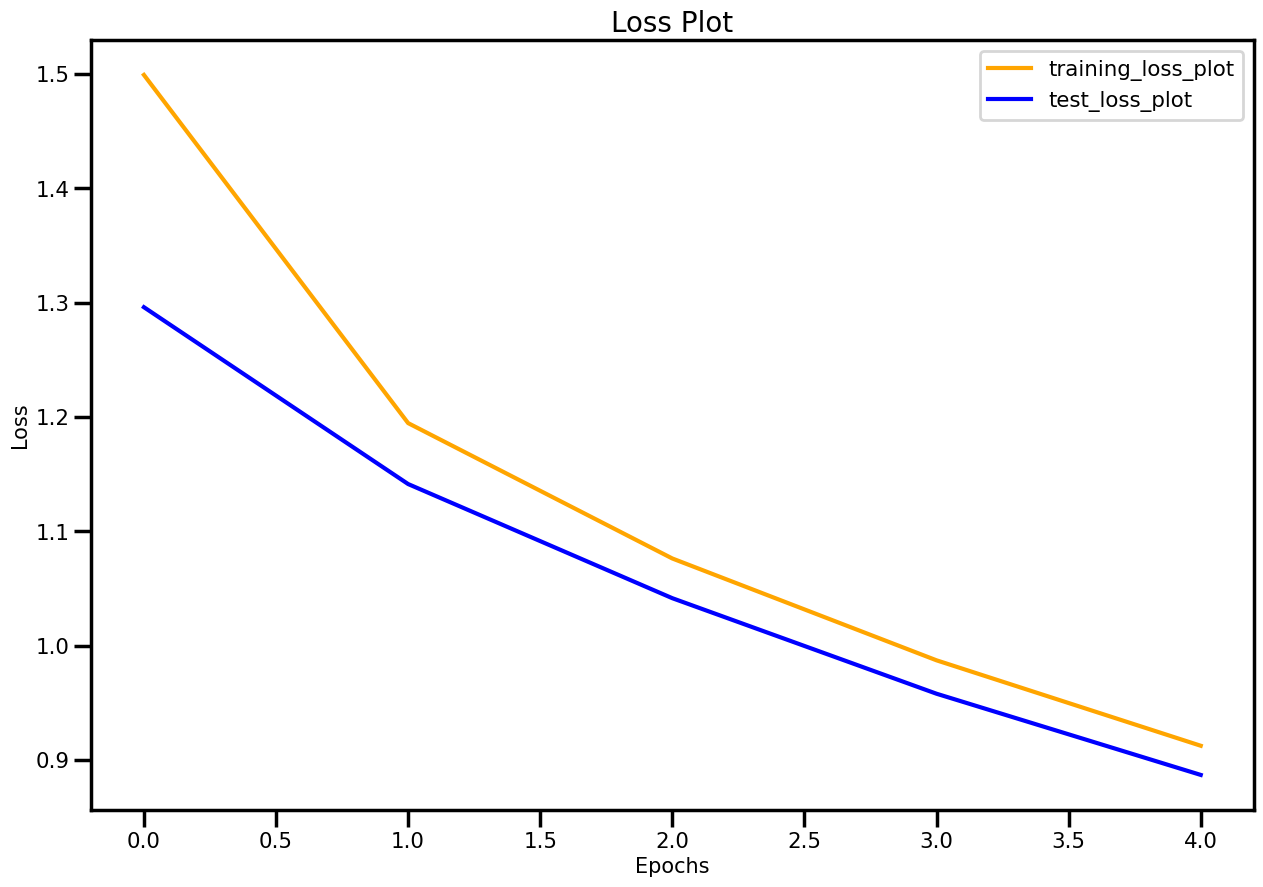

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(15, 10))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='b', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'black')
plt.ylabel('Loss', fontsize = 15, color = 'black')
plt.title('Loss Plot', fontsize = 20, color = 'black')
plt.legend()
plt.show()

<h2>Model Evaluation</h2>

In [ ]:
def evaluate(image):
    # attention 가중치 저장할 배열 생성 및 초기화
    attention_plot = np.zeros((max_length, attention_feature_shape))

    # Decoder 초기 은닉 상태 생성
    hidden = decoder.init_state(batch_size=1)

    # 이미지 전처리 및 Feature extracting
    temp_input = tf.expand_dims(load_images(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # 이미지 특성으로부터 Encoder 특성 계산
    features = encoder (img_tensor_val)

    # Decoder 초기 입력 시작 토큰 <start> 사용
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        # Decoder 호출해 예측, 은닉, 어텐션 가중치 계산
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # 가장 높은 확률 가진 단어를 선택
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append (tokenizer.index_word[predicted_id])

        #종료 토큰이 생성되면 결과 반환
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        # 다음 디코더 입력으로 예측된 단어를 사용
        dec_input = tf.expand_dims([predicted_id], 0)

    # 생성 캡션 길이에 맞게 어텐션 가중치 잘라냄
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [ ]:
def plot_attention_map (caption, weights, image) :

  fig = plt.figure(figsize = (20, 20))
  temp_img = np.array(Image.open(image))

  cap_len = len(caption)
  for cap in range(cap_len) :
    # 어텐션 가중치 이미지 크기 조정
    weights_img = np.reshape(weights[cap], (8,8))
    wweights_img = np.array(Image.fromarray(weights_img).resize((224,224), Image.LANCZOS))

    ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
    ax.set_title(caption[cap], fontsize = 14, color = 'red')

    img = ax.imshow(temp_img)

    ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
    ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

In [ ]:
#from nltk.translate.bleu_score import sentence_bleu

In [ ]:
encoder.save_weights('./outputs_encoder')
decoder.save_weights('./outputs_decoder')